# Quantum bounds for a parametric Bell expression

Consider a setting where nparties share a global state $\ket{\psi}$ on which they may perform mdifferent local measurements with $k$ possible outcomes. This experiment is described by the conditional probability distribution 

$$P= P(a_1, \dots, a_n| x_1, \dots, x_n)$$

of observing the outcomes $a_i = 1, \dots, $ given the possible measurement settings $x_i = 1, \dots, m$. A Bell expression $\beta$ in this scenario is a linear map that associates a Bell score

$$\vec{\beta} \cdot \vec{P} \equiv \beta(P) = \sum_{a, x} \alpha_{a|x} P(a|x)$$

to every probability distribution $P$. Here, $\alpha_{a|x}$ are the Bell expression’s coefficients and $a =
(a_1, \dots, a_n)$, $x = (x_1, \dots, x_n)$ are vectors containing the outcomes and setting choices of all parties.

Given a choice of measurement projectors $\{\hat{\Pi}^{(i)}_{a|x}\}$, with $\hat{\Pi}^{(i)}_{a|x} \in \mathcal{L}(\mathcal{H}^{(i)})$ and $\sum_a \hat{\Pi}^{(i)}_{a|x} = 1$, a Bell expression $\beta$ gives rise to a Bell operator

$$\hat{S} = \sum_{a,x} \alpha_{a|x} $$

which acts on the full Hilbert space $\mathcal{H} = \mathcal{H}^{(1)} \otimes \dots \otimes \mathcal{H}^{(n)}$: $\hat{S} \in \mathcal{L}(\mathcal{H})$. In the case of binary outcomes ($k = 2$), the measurements can also be described in terms of measurement operators:

$$\hat{M}^{(i)}_x \equiv \hat{\Pi}^{(i)}_{1|x} - \hat{\Pi}_{2|x}^{(i)}$$

with eigenvalue $\pm 1$ for each party. 

## Bell expression

We are considering the Bell expression

$$\beta_{p_1, p_4} = \dots$$

and we want to find a bound for the Bell expression for every choice of $(r_0, r_1)$.

We start by importing the following libraries

In [1]:
import numpy as np
import ncpol2sdpa as ncp
from ncpol2sdpa import *
import matplotlib.pyplot as plt
import json

We define the settings and the operators

In [2]:
A_config = [2,2]
B_config = [2,2]

# Operators in problem
A = [Ai for Ai in ncp.generate_measurements(A_config, 'A')]
B = [Bj for Bj in ncp.generate_measurements(B_config, 'B')]

We define functions for adding extra monomials to the relaxation:

In [3]:
def get_extra_monomials():
    """
    Returns additional monomials to add to sdp relaxation.
    """

    monos = []

    Aflat = ncp.flatten(A)
    Bflat = ncp.flatten(B)

    # ABB
    for a in Aflat:
        for b in Bflat:
            for b2 in Bflat:
                monos += [a*b*b2]
    # AAB
    for a in Aflat:
        for a2 in Aflat:
            for b in Bflat:
                monos += [a*a2*b]

    #AB
    for a in Aflat:
        for b in Bflat:
            monos += [a*b]
    
    
    return monos[:]

def get_subs():
    """
    Returns any substitution rules to use with ncpol2sdpa. E.g. projections and
    commutation relations.
    """
    subs = {}
    # Get Alice and Bob's projective measurement constraints
    subs.update(ncp.projective_measurement_constraints(A,B))

    return subs

We are now ready to perform the relaxation and get the Tsirelson bound! But first, we have to change notation. Since 

$$\hat{\Pi}_{a|x}^{(i=0)} = \hat{A}_{a|x}, \quad \hat{\Pi}_{b|y}^{(i=1)} = \hat{B}_{b|y},$$

we have

$$\hat{A}_x = 2 \hat{A}_{0|x} - 1, \qquad \hat{B}_y = 2 \hat{B}_{0|y} - 1.$$

In this notation, expanding, the Bell expression reads:

In [4]:
substitutions = get_subs()             # substitutions used in ncpol2sdpa
moment_ineqs = []                      # moment inequalities
moment_eqs = []                        # moment equalities
op_eqs = []                            # operator equalities
op_ineqs = []                          # operator inequalities
extra_monos = get_extra_monomials()    # extra monomials

# Bounds on the parameters of sys
ops = ncp.flatten([A,B])        # Base monomials involved in problem

In [6]:
LEVEL = 1
p1 = 0
p4 = 0
Theta = np.pi/4
s = np.sqrt(2)

obj = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))

sdp = ncp.SdpRelaxation(ops, verbose = 0, normalized=True, parallel=0)
sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
sdp.solve('mosek')
print(-sdp.dual)

1.000000005636052


We may try to create a grid in the $(p_1, p_4)$ plane and determine the quantum bound for every pixel of the grid!

In [10]:
Theta = np.pi/4
s = np.sqrt(2)

# Define a grid in the (p1, p4) plane
p1_vals = np.linspace(-0.5, 0.5, 100)  # Adjust resolution as needed
p4_vals = np.linspace(0.0, 0.5, 50)
LEVEL = 2

# Store results
quantum_bounds = np.zeros((len(p1_vals), len(p4_vals)))

# Loop over (p1, p4) values
for i, p1 in enumerate(p1_vals):
    for j, p4 in enumerate(p4_vals):

        obj = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))


        sdp = ncp.SdpRelaxation(ops, verbose = 0, normalized=True, parallel=0)
        sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
        sdp.solve('mosek')

        # Store the quantum bound at this (p1, p4)
        quantum_bounds[i, j] = -sdp.dual

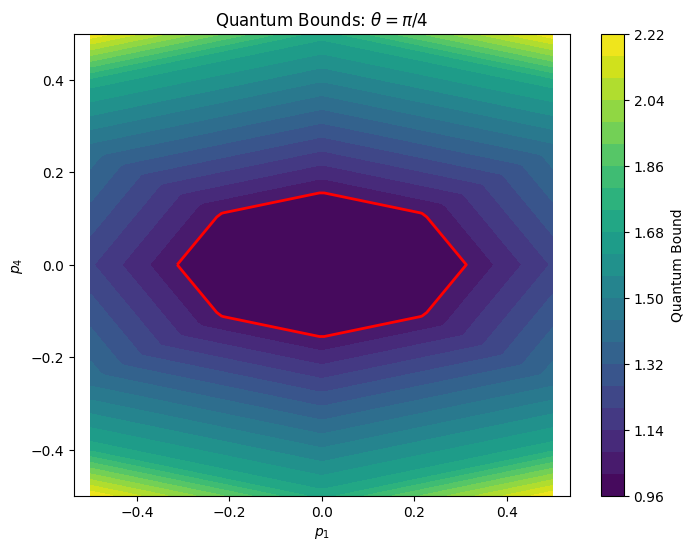

In [11]:
# Exploiting p4 -> -p4 symmetry
p4_vals_full = np.concatenate((-p4_vals[::-1], p4_vals))
quantum_bounds_full = np.concatenate((quantum_bounds[:, ::-1], quantum_bounds), axis=1)

# Meshgrid for the full range
P1, P4 = np.meshgrid(p1_vals, p4_vals_full, indexing='ij')

plt.figure(figsize=(8, 6))
plt.contourf(P1, P4, quantum_bounds_full, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")
plt.xlabel("$p_1$")
plt.ylabel("$p_4$")
plt.title(r"Quantum Bounds: $\theta = \pi/4$")
contour_line = plt.contour(P1, P4, quantum_bounds_full, levels=[1.02], colors='red', linewidths=2)
#plt.clabel(contour_line, fmt="Quantum Bound = 1", inline=True, fontsize=10)
plt.axis('equal')
plt.show()

The NPA hierarchy conditions are asymptotically complete, but at this level they provide a necessary but not sufficient condition for the dual of the quantum set. But in this case, since at this level of the hierarchy, we have saturated the dual local bounds, which are contained in the dual quantum bounds, they provide a complete description of the dual quantum set for the Tsirelson point!

## Different values of $\theta$

We now consider different values of $\theta \in [\frac{\pi}{8} + \frac{\pi}{64}, \frac{\pi}{4}]$:

In [12]:
Theta = np.pi/8 + np.pi/(64)
s = np.sqrt(2)

# Define a grid in the (p1, p4) plane
p1_vals = np.linspace(-0.5, 0.5, 100)  # Adjust resolution as needed
p4_vals = np.linspace(0.0, 0.5, 50)
LEVEL = 2

# Store results
quantum_bounds = np.zeros((len(p1_vals), len(p4_vals)))

# Loop over (r0, r1) values
for i, p1 in enumerate(p1_vals):
    for j, p4 in enumerate(p4_vals):

        obj = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))


        sdp = ncp.SdpRelaxation(ops, verbose = 0, normalized=True, parallel=0)
        sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
        sdp.solve('mosek')

        # Store the quantum bound at this (r0, r1)
        quantum_bounds[i, j] = -sdp.dual

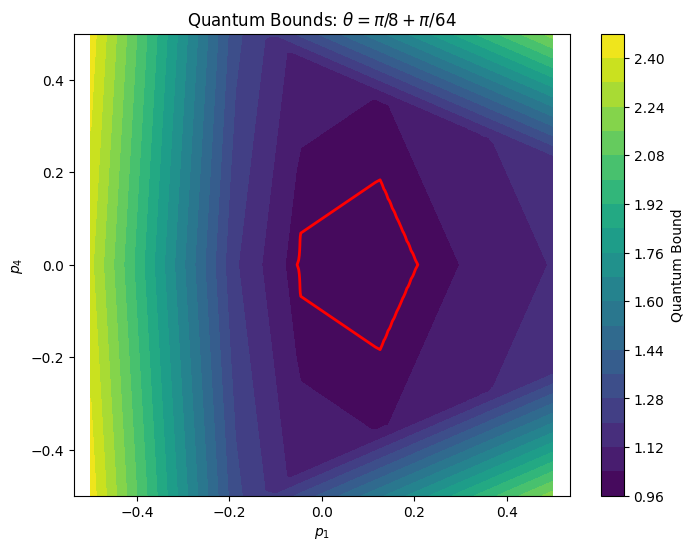

In [55]:
# Exploiting p4 -> -p4 symmetry
p4_vals_full = np.concatenate((-p4_vals[::-1], p4_vals))
quantum_bounds_full = np.concatenate((quantum_bounds[:, ::-1], quantum_bounds), axis=1)

# Meshgrid for the full range
P1, P4 = np.meshgrid(p1_vals, p4_vals_full, indexing='ij')

plt.figure(figsize=(8, 6))
plt.contourf(P1, P4, quantum_bounds_full, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")
plt.xlabel("$p_1$")
plt.ylabel("$p_4$")
plt.title(r"Quantum Bounds: $\theta = \pi/8 + \pi/64$")
contour_line = plt.contour(P1, P4, quantum_bounds_full, levels=[1.002], colors='red', linewidths=2)
#plt.clabel(contour_line, inline=False, fontsize=10)
plt.axis('equal')
plt.show()

In [28]:
Theta = np.pi/8 + np.pi/(32)
s = np.sqrt(2)

# Define a grid in the (p1, p4) plane
p1_vals = np.linspace(-0.5, 0.5, 100)  # Adjust resolution as needed
p4_vals = np.linspace(0.0, 0.5, 50)
LEVEL = 2

# Store results
quantum_bounds = np.zeros((len(p1_vals), len(p4_vals)))

# Loop over (r0, r1) values
for i, p1 in enumerate(p1_vals):
    for j, p4 in enumerate(p4_vals):

        obj = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))


        sdp = ncp.SdpRelaxation(ops, verbose = 0, normalized=True, parallel=0)
        sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
        sdp.solve('mosek')

        # Store the quantum bound at this (r0, r1)
        quantum_bounds[i, j] = -sdp.dual

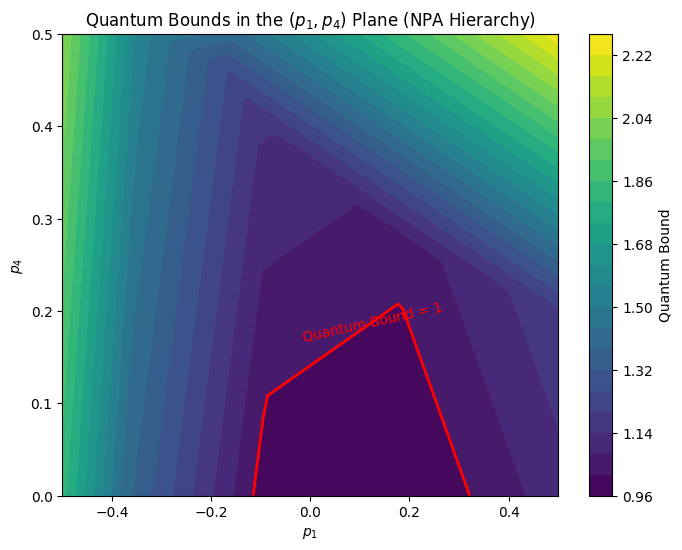

In [ ]:
# Exploiting p4 -> -p4 symmetry
p4_vals_full = np.concatenate((-p4_vals[::-1], p4_vals))
quantum_bounds_full = np.concatenate((quantum_bounds[:, ::-1], quantum_bounds), axis=1)

# Meshgrid for the full range
P1, P4 = np.meshgrid(p1_vals, p4_vals_full, indexing='ij')

plt.figure(figsize=(8, 6))
plt.contourf(P1, P4, quantum_bounds_full, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")
plt.xlabel("$p_1$")
plt.ylabel("$p_4$")
plt.title(r"Quantum Bounds: $\theta = \pi/4 - \pi/32$")
contour_line = plt.contour(P1, P4, quantum_bounds_full, levels=[1.02], colors='red', linewidths=2)
#plt.clabel(contour_line, fmt="Quantum Bound = 1", inline=True, fontsize=10)
plt.axis('equal')
plt.show()

In [30]:
Theta = np.pi/4 - np.pi/(32)
s = np.sqrt(2)

# Define a grid in the (p1, p4) plane
p1_vals = np.linspace(-0.5, 0.5, 100)  # Adjust resolution as needed
p4_vals = np.linspace(0.0, 0.5, 50)
LEVEL = 2

# Store results
quantum_bounds = np.zeros((len(p1_vals), len(p4_vals)))

# Loop over (r0, r1) values
for i, p1 in enumerate(p1_vals):
    for j, p4 in enumerate(p4_vals):

        obj = 1/4*p4*(4*(-2 + 4*A[1][0]) - 8*s*(-1 + 2*A[1][0])*(-1 + B[0][0] + B[1][0])*np.cos(2*Theta) + 8*s*(-B[0][0] + B[1][0])*np.sin(2*Theta)) +  1/4*(4*s - 8*s*A[0][0] - 4*s*B[0][0] + 8*s*A[0][0]*B[0][0] - 4*s*B[1][0] + 8*s*A[0][0]*B[1][0] + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) - s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta)) + 1/4*p1*(2*(-2 + s) + 8*A[0][0] - 2*s*B[0][0] - 2*s*B[1][0] - s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*1/np.tan(Theta) + s*(-1 + A[0][0])*(-1 + B[0][0] + B[1][0])*1/(np.sin(Theta))**2 - s*A[0][0]*(-1 + B[0][0] + B[1][0])*1/(np.cos(Theta))**2 + s*(-1 + 2*A[1][0])*(B[0][0] - B[1][0])*np.tan(Theta))


        sdp = ncp.SdpRelaxation(ops, verbose = 0, normalized=True, parallel=0)
        sdp.get_relaxation(level = LEVEL,
                    equalities = op_eqs[:],
                    inequalities = op_ineqs[:],
                    momentequalities = moment_eqs[:],
                    momentinequalities = moment_ineqs[:],
                    objective = -obj,
                    substitutions = substitutions,
                    extramonomials = extra_monos)
        sdp.solve('mosek')

        # Store the quantum bound at this (r0, r1)
        quantum_bounds[i, j] = -sdp.dual

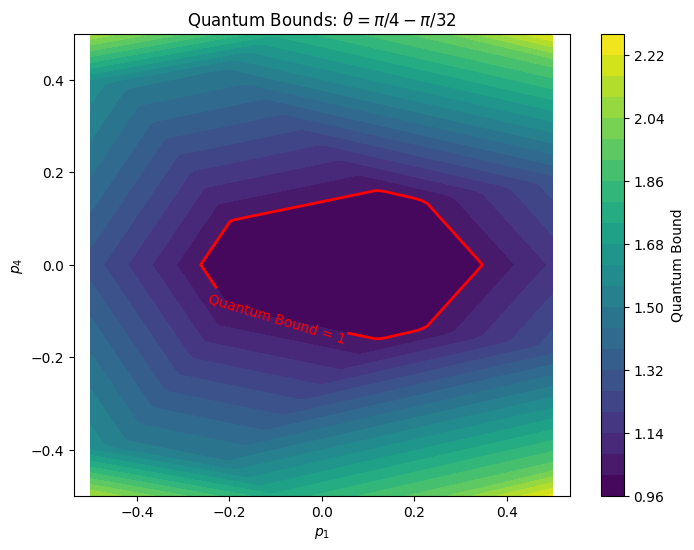

In [40]:
# Exploiting p4 -> -p4 symmetry
p4_vals_full = np.concatenate((-p4_vals[::-1], p4_vals))
quantum_bounds_full = np.concatenate((quantum_bounds[:, ::-1], quantum_bounds), axis=1)

# Meshgrid for the full range
P1, P4 = np.meshgrid(p1_vals, p4_vals_full, indexing='ij')

plt.figure(figsize=(8, 6))
plt.contourf(P1, P4, quantum_bounds_full, levels=20, cmap="viridis")
plt.colorbar(label="Quantum Bound")
plt.xlabel("$p_1$")
plt.ylabel("$p_4$")
plt.title(r"Quantum Bounds: $\theta = \pi/4 - \pi/32$")
contour_line = plt.contour(P1, P4, quantum_bounds_full, levels=[1.02], colors='red', linewidths=2)
plt.clabel(contour_line, fmt="Quantum Bound = 1", inline=True, fontsize=10)
plt.axis('equal')
plt.show()

## Different method

We now want to write a code to solve the following SDP problem:

Let $p_1 = r\cos{\phi}$, $p_4 = r\sin{\phi}$. Then, for a fixed polar angle $\phi$, we look for

$$\min_{\beta_{p_1, p_4}^\mathcal{Q} \geq 1}{r}$$

where

$$r \geq 0$$